In [2]:
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis as cfv
import calfem.vis_mpl as cfvl
import numpy as np
from numba import njit
import random
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import pandas as pd
import time


def mean_square(coords, polygons):
    
    S_el = lambda poly: ((coords[poly[1] - 1][0] - coords[poly[0] - 1][0]) * (coords[poly[2] - 1][1] - coords[poly[0] - 1][1]) - (coords[poly[2] - 1][0] - coords[poly[0] - 1][0]) * (coords[poly[1] - 1][1] - coords[poly[0] - 1][1])) / 2
    res = 0.
    for el in polygons:
        res += S_el(el)
    return round(res / len(polygons), 8)

def max_square(coords, polygons):
    
    S_el = lambda poly: ((coords[poly[1] - 1][0] - coords[poly[0] - 1][0]) * (coords[poly[2] - 1][1] - coords[poly[0] - 1][1]) - (coords[poly[2] - 1][0] - coords[poly[0] - 1][0]) * (coords[poly[1] - 1][1] - coords[poly[0] - 1][1])) / 2
    S_max = 0.
    tmp = 0.
    for el in polygons:
        tmp = S_el(el)
        if (tmp > S_max):
            S_max = tmp
    return round(S_max, 8)

def plot_fem_mesh(nodes, elements, linewidth: float = 0.2):

    plt.rcParams["figure.figsize"] = [4, 4]
    plt.rcParams["figure.autolayout"] = True
    it = 0
    for element in elements:
        x = [nodes[element[0] - 1][0], nodes[element[1] - 1][0], nodes[element[2] - 1][0]]
        y = [nodes[element[0] - 1][1], nodes[element[1] - 1][1], nodes[element[2] - 1][1]]
        plt.fill(x, y, edgecolor='black', linewidth = linewidth, fill=False)
        it += 1

def reshape_boundary_dict(bdofs):
    nodeset = set([0])
    for array in bdofs.items():
        nodeset.update(array[1])
    new = np.zeros(len(nodeset)-1)
    for key in bdofs:
        for elem in bdofs[key]:
            new[elem-1] = key
    return new

### Define Geometry

Info    : GMSH -> Python-module
Info    : Reading '/tmp/tmps5b04o_p/tempGeometry.geo'...
Info    : Done reading '/tmp/tmps5b04o_p/tempGeometry.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Nurb)
Info    : [ 30%] Meshing curve 2 (Nurb)
Info    : [ 50%] Meshing curve 3 (Nurb)
Info    : [ 80%] Meshing curve 4 (Nurb)
Info    : Done meshing 1D (Wall 0.0168862s, CPU 0.010154s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 0.454803s, CPU 0.446044s)
Info    : 16352 nodes 32587 elements
Info    : Writing '/tmp/tmps5b04o_p/meshFile.msh'...
Info    : Done writing '/tmp/tmps5b04o_p/meshFile.msh'
mean:  0.00075519
max:  0.00105162
[ 0.  0.  0.  0. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80.

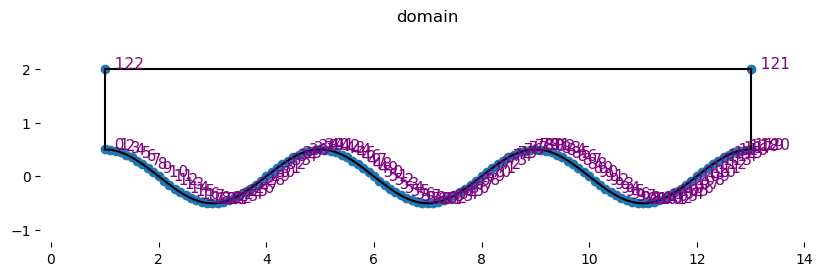

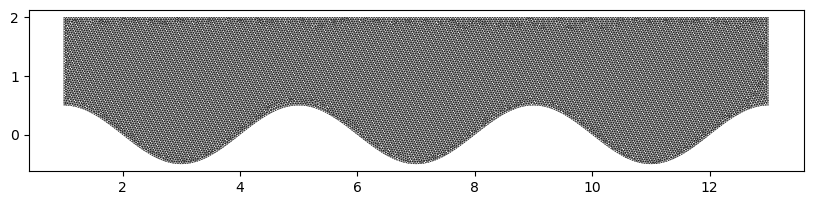

In [3]:
g = cfg.Geometry()

p_coords = []

h = 0.1
x = 1.
ind = []


while x <= 13:
    ind.append(len(p_coords))
    p_coords.append([round(x, 2), 1 / 2 * np.sin( np.pi / 2 * round(x, 2))])
    x = round(x + h, 2)
    # print([p_coords[-1], len(p_coords) - 1])
    g.point(p_coords[-1], len(p_coords) - 1)

g.spline(ind.copy(), 0)

# print(ind)

g.point([13., 2.], ind[-1] + 1)
ind.append(ind[-1] + 1)


g.spline([ind[-2], ind[-1]] , 1)


g.point([1., 2.], ind[-1] + 1)
ind.append(ind[-1] + 1)

g.spline([ind[-2], ind[-1]] , 2)


g.spline([ind[-1], 0] , 3)


g.surface([0, 1, 2, 3])

for curveID in [0]:
    g.curveMarker(curveID, 80)


cfvl.figure(fig_size=(10,5))
cfvl.draw_geometry(
        g,
        
        label_curves=False,
        title="domain"
)


mesh = cfm.GmshMesh(g)
mesh.elType = 2          # Degrees of freedom per node.
mesh.dofsPerNode = 1     # Factor that changes element sizes.
mesh.elSizeFactor = 0.042 # Element size Factor 
"""
    mesh.elSizeFactor = 0.3325  ~   max S_el = 0.05
    mesh.elSizeFactor = 0.1425  ~   max S_el = 0.01
    mesh.elSizeFactor = 0.042   ~   max S_el = 0.001
    0.029 ~ 0.0005
"""
coords, edof, dofs, bdofs, elementmarkers = mesh.create()

print("mean: ", mean_square(coords, edof))
print("max: ", max_square(coords, edof))
boundary_voltages = reshape_boundary_dict(bdofs)
print(boundary_voltages)

cfvl.figure(fig_size=(10,5))
cfvl.draw_mesh(
    coords=coords,
    edof=edof,
    dofs_per_node=mesh.dofs_per_node,
    el_type=mesh.el_type,
    filled=False,
    #title="Example 2 - Mesh"
)
#plot_fem_mesh(coords, edof)


In [322]:
# for i in reversed(range(44, 51)):
#     print(f"""{2.0}, {coords[i][1]}""")

for i in reversed(range(242, 277)):
    # print(f"""{round(coords[i][0],2)}, {round(coords[i][1],2)}""")
    print(f"""5.0, {round(coords[i][1],2)}""")

# print(f"""x,y""")
# for i in coords:
#     print(f"""{i[0]}, {i[1]}""")

5.0, 0.54
5.0, 0.58
5.0, 0.62
5.0, 0.67
5.0, 0.71
5.0, 0.75
5.0, 0.79
5.0, 0.83
5.0, 0.87
5.0, 0.92
5.0, 0.96
5.0, 1.0
5.0, 1.04
5.0, 1.08
5.0, 1.12
5.0, 1.17
5.0, 1.21
5.0, 1.25
5.0, 1.29
5.0, 1.33
5.0, 1.37
5.0, 1.42
5.0, 1.46
5.0, 1.5
5.0, 1.54
5.0, 1.58
5.0, 1.62
5.0, 1.67
5.0, 1.71
5.0, 1.75
5.0, 1.79
5.0, 1.83
5.0, 1.87
5.0, 1.92
5.0, 1.96


In [323]:
print(f"""p1,p2,p3""")
for i in edof:
    print(f"""{i[0]}, {i[1]}, {i[2]}""")

p1,p2,p3
321, 3219, 5307
3214, 289, 3216
387, 3213, 4260
317, 3579, 5334
291, 3187, 3193
303, 3796, 5311
3228, 320, 4793
3213, 387, 5233
298, 3575, 3710
3252, 331, 5234
3313, 2356, 3314
5232, 4316, 5236
4623, 5139, 5280
185, 3395, 5431
228, 3967, 5443
373, 3185, 3218
3187, 291, 3201
3216, 289, 3280
4564, 3553, 5383
306, 4564, 5383
3253, 3252, 5234
3281, 338, 5340
338, 3281, 5364
384, 3189, 5411
3185, 373, 3239
352, 3182, 4262
3579, 3164, 5334
185, 186, 3395
362, 3625, 4311
2685, 3248, 5304
5306, 3199, 5416
3224, 4695, 5367
228, 229, 3967
3145, 2399, 3265
4793, 320, 5342
3225, 294, 4361
3799, 2900, 5271
3199, 347, 5109
3224, 3223, 4695
3182, 352, 5270
5270, 352, 5332
3219, 3385, 5307
299, 5306, 5416
113, 114, 3249
3709, 298, 3710
3170, 3171, 4565
3701, 5270, 5332
5249, 3644, 5304
3195, 371, 3233
351, 4110, 4263
3248, 2685, 5160
3342, 3343, 4534
2632, 2710, 3271
4268, 3173, 5361
3281, 2951, 3332
359, 3198, 3550
3170, 4565, 5383
5313, 4560, 5347
319, 5313, 5347
4861, 375, 4974
3796, 3149,

Info    : GMSH -> Python-module
Info    : Reading '/tmp/tmp4lk0j16z/tempGeometry.geo'...
Info    : Done reading '/tmp/tmp4lk0j16z/tempGeometry.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Nurb)
Info    : [ 30%] Meshing curve 2 (Nurb)
Info    : [ 50%] Meshing curve 3 (Nurb)
Info    : [ 80%] Meshing curve 4 (Nurb)
Info    : Done meshing 1D (Wall 0.0168822s, CPU 0.016924s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 0.461595s, CPU 0.461231s)
Info    : 16352 nodes 32587 elements
Info    : Writing '/tmp/tmp4lk0j16z/meshFile.msh'...
Info    : Done writing '/tmp/tmp4lk0j16z/meshFile.msh'
mean:  0.00075519
max:  0.00105162
[ 0.  0.  0.  0. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80.

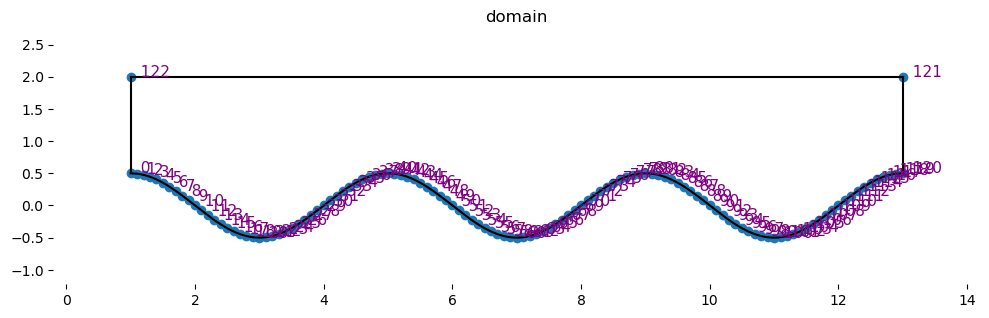

In [313]:
g = cfg.Geometry()

p_coords = []

h = 0.1
x = 1.
ind = []


while x <= 13:
    ind.append(len(p_coords))
    p_coords.append([round(x, 2), 1 / 2 * np.sin( np.pi / 2 * round(x, 2))])
    x = round(x + h, 2)
    # print([p_coords[-1], len(p_coords) - 1])
    g.point(p_coords[-1], len(p_coords) - 1)

g.spline(ind.copy(), 0)

# print(ind)

g.point([13., 2.], ind[-1] + 1)
ind.append(ind[-1] + 1)


g.spline([ind[-2], ind[-1]] , 1)


g.point([1., 2.], ind[-1] + 1)
ind.append(ind[-1] + 1)

g.spline([ind[-2], ind[-1]] , 2)


g.spline([ind[-1], 0] , 3)


g.surface([0, 1, 2, 3])

for curveID in [0]:
    g.curveMarker(curveID, 80)


cfvl.figure(fig_size=(10,5))
cfvl.draw_geometry(
        g,
        
        label_curves=False,
        title="domain"
)


mesh = cfm.GmshMesh(g)
mesh.elType = 2          # Degrees of freedom per node.
mesh.dofsPerNode = 1     # Factor that changes element sizes.
mesh.elSizeFactor = 0.042 # Element size Factor 
"""
    mesh.elSizeFactor = 0.3325  ~   max S_el = 0.05
    mesh.elSizeFactor = 0.1425  ~   max S_el = 0.01
    mesh.elSizeFactor = 0.042   ~   max S_el = 0.001
    0.029 ~ 0.0005
"""
coords, edof, dofs, bdofs, elementmarkers = mesh.create()

print("mean: ", mean_square(coords, edof))
print("max: ", max_square(coords, edof))
boundary_voltages = reshape_boundary_dict(bdofs)
print(boundary_voltages)

# cfvl.figure(fig_size=(10,5))
# cfvl.draw_mesh(
#     coords=coords,
#     edof=edof,
#     dofs_per_node=mesh.dofs_per_node,
#     el_type=mesh.el_type,
#     filled=False,
#     #title="Example 2 - Mesh"
# )
# #plot_fem_mesh(coords, edof)


In [316]:
# for i in reversed(range(44, 51)):
#     print(f"""{2.0}, {coords[i][1]}""")

for i in reversed(range(649, 685)):
    # print(f"""{round(coords[i][0],2)}, {round(coords[i][1],2)}""")
    print(f"""13.0, {round(coords[i][1],2)}""")

# print(f"""x,y""")
# for i in coords:
#     print(f"""{i[0]}, {i[1]}""")

13.0, -0.2
13.0, 0.54
13.0, 0.58
13.0, 0.62
13.0, 0.67
13.0, 0.71
13.0, 0.75
13.0, 0.79
13.0, 0.83
13.0, 0.87
13.0, 0.92
13.0, 0.96
13.0, 1.0
13.0, 1.04
13.0, 1.08
13.0, 1.12
13.0, 1.17
13.0, 1.21
13.0, 1.25
13.0, 1.29
13.0, 1.33
13.0, 1.37
13.0, 1.42
13.0, 1.46
13.0, 1.5
13.0, 1.54
13.0, 1.58
13.0, 1.62
13.0, 1.67
13.0, 1.71
13.0, 1.75
13.0, 1.79
13.0, 1.83
13.0, 1.87
13.0, 1.92
13.0, 1.96


In [317]:
print(f"""p1,p2,p3""")
for i in edof:
    print(f"""{i[0]}, {i[1]}, {i[2]}""")

p1,p2,p3
909, 9426, 15818
11114, 943, 11115
11741, 15669, 15988
931, 12782, 12783
10164, 9180, 10167
8332, 10547, 10548
9503, 801, 15754
9661, 7035, 9662
943, 160, 11115
9509, 912, 10331
912, 9509, 10330
9372, 768, 9633
15669, 6362, 15988
7032, 8420, 9476
12640, 797, 15620
9381, 889, 12378
9180, 10164, 15663
735, 9321, 16039
8343, 8355, 10128
9378, 814, 9379
703, 12688, 15680
843, 12484, 15033
198, 199, 9564
774, 10110, 15825
9448, 9644, 16091
9355, 778, 10127
6945, 9520, 14341
15603, 12830, 15786
796, 9432, 9518
861, 9861, 15000
9240, 12468, 12469
541, 542, 9430
11108, 6350, 11109
11109, 6350, 11110
9321, 735, 15295
9240, 12469, 15697
464, 465, 9643
779, 9992, 9994
15574, 9268, 15692
821, 9461, 9463
762, 9373, 9391
803, 9502, 9527
10331, 775, 15651
9502, 803, 9526
9426, 9993, 15818
720, 9377, 15650
329, 2, 16020
9369, 933, 9539
876, 9329, 9476
9412, 945, 9413
9163, 15583, 15676
12811, 927, 15575
11756, 5730, 11758
821, 9460, 9461
9175, 9173, 9683
9329, 876, 9459
943, 11114, 11116
9145

In [162]:
# g = cfg.Geometry()

# g.point([0.0, 1.0]) # point 0
# g.point([1.0, 0.0]) # point 1
# g.point([2.0, 1.0]) # point 2

# g.point([2.0, 2.0]) # point 3
# g.point([0.0, 2.0]) # point 4

# # g.point([3.0, 0.0]) # point 1
# # g.point([4.0, 1.0]) # point 2
# # g.point([4.0, 2.0]) # point 2
# # g.point([0.0, 2.0]) # point 2


# # g.point([5.0, 0.0]) 
# # g.point([6.0, 1.0]) 
# # g.point([6.0, 2.0]) 
# # g.point([0.0, 2.0]) 


# g.spline([0, 1], marker=10) # line 0
# g.spline([1, 2], marker=10) # line 1
# g.spline([2, 3], marker=10) # line 2
# g.spline([3, 4], marker=10) # line 3
# g.spline([4, 0], marker=10) # line 4


# # g.spline([5, 6], marker=10) # line 3
# # g.spline([6, 7], marker=0) # line 3
# # g.spline([7, 8], marker=0) # line 3
# # g.spline([8, 0], marker=0) # line 3


# g.surface([0, 1, 2, 3, 4 ]) #, 5, 6, 7, 8])


### Generate Mesh

In [174]:
def reshape_boundary_dict(bdofs):
    nodeset = set([0])
    for array in bdofs.items():
        nodeset.update(array[1])
    new = np.zeros(len(nodeset)-1)
    for key in bdofs:
        for elem in bdofs[key]:
            new[elem-1] = key
    return new

In [211]:
mesh = cfm.GmshMesh(g)
mesh.elType = 2          # Degrees of freedom per node.
mesh.dofsPerNode = 1     # Factor that changes element sizes.
mesh.elSizeFactor = 0.1 # Element size Factor 
"""
    mesh.elSizeFactor = 0.3325  ~   max S_el = 0.05
    mesh.elSizeFactor = 0.1425  ~   max S_el = 0.01
    mesh.elSizeFactor = 0.042   ~   max S_el = 0.001
    0.029 ~ 0.0005
"""
coords, edof, dofs, bdofs, elementmarkers = mesh.create()

print("mean: ", mean_square(coords, edof))
print("max: ", max_square(coords, edof))
boundary_voltages = reshape_boundary_dict(bdofs)
print(boundary_voltages)

Info    : GMSH -> Python-module
Info    : Reading '/tmp/tmpvazl9q8k/tempGeometry.geo'...
Info    : Done reading '/tmp/tmpvazl9q8k/tempGeometry.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Nurb)
Info    : [ 30%] Meshing curve 2 (Nurb)
Info    : [ 50%] Meshing curve 3 (Nurb)
Info    : [ 80%] Meshing curve 4 (Nurb)
Info    : Done meshing 1D (Wall 0.00442682s, CPU 0.004481s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0214874s, CPU 0.021683s)
Info    : 1028 nodes 2051 elements
Info    : Writing '/tmp/tmpvazl9q8k/meshFile.msh'...
Info    : Done writing '/tmp/tmpvazl9q8k/meshFile.msh'
mean:  0.0041641
max:  0.00562823
[ 0.  0.  0.  0. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  

In [212]:
print("mean: ", mean_square(coords, edof))
print("max: ", max_square(coords, edof))
boundary_voltages = reshape_boundary_dict(bdofs)
print(boundary_voltages)

mean:  0.0041641
max:  0.00562823
[ 0.  0.  0.  0. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]


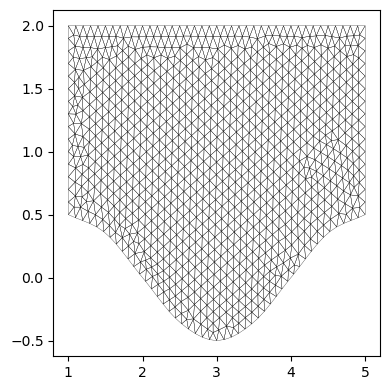

In [213]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import pandas as pd
import numpy as np
from numba import njit
import time

def plot_fem_mesh(nodes, elements, linewidth: float = 0.2):

    plt.rcParams["figure.figsize"] = [4, 4]
    plt.rcParams["figure.autolayout"] = True
    it = 0
    for element in elements:
        x = [nodes[element[0] - 1][0], nodes[element[1] - 1][0], nodes[element[2] - 1][0]]
        y = [nodes[element[0] - 1][1], nodes[element[1] - 1][1], nodes[element[2] - 1][1]]
        plt.fill(x, y, edgecolor='black', linewidth = linewidth, fill=False)
        it += 1


plot_fem_mesh(coords, edof)

In [56]:
for i in reversed(range(44, 51)):
    print(f"""{2.0}, {coords[i][1]}""")

# print(f"""x,y""")
# for i in coords:
#     print(f"""{i[0]}, {i[1]}""")

2.0, 1.124999999138059
2.0, 1.24999999838454
2.0, 1.374999998346593
2.0, 1.499999998200225
2.0, 1.624999998487539
2.0, 1.749999999121797
2.0, 1.874999999929527


In [54]:
print(f"""p1,p2,p3""")
for i in edof:
    print(f"""{i[0]}, {i[1]}, {i[2]}""")

p1,p2,p3
60, 23, 70
6, 62, 117
60, 70, 71
152, 58, 167
72, 74, 168
151, 63, 190
63, 151, 198
58, 165, 167
117, 62, 201
68, 151, 190
151, 68, 209
117, 166, 207
52, 147, 213
150, 65, 152
166, 117, 201
69, 178, 211
196, 36, 213
119, 72, 168
21, 22, 119
147, 52, 192
74, 107, 168
178, 133, 211
1, 6, 117
23, 3, 70
21, 119, 123
156, 63, 198
149, 196, 213
152, 65, 202
147, 149, 213
118, 53, 200
63, 156, 206
56, 163, 208
163, 56, 204
53, 118, 220
160, 148, 162
122, 195, 197
10, 125, 222
164, 39, 208
39, 164, 210
120, 59, 122
148, 160, 184
58, 152, 202
22, 60, 119
125, 10, 205
160, 159, 184
59, 120, 124
195, 122, 216
165, 58, 196
170, 54, 222
60, 71, 72
53, 20, 123
20, 21, 123
67, 172, 197
131, 161, 163
162, 148, 192
105, 111, 124
120, 105, 124
148, 147, 192
55, 156, 215
159, 92, 184
197, 172, 203
153, 92, 182
156, 55, 206
155, 154, 156
126, 96, 127
135, 115, 154
95, 96, 126
62, 7, 134
68, 193, 209
161, 131, 173
136, 154, 155
73, 115, 135
127, 132, 157
123, 119, 168
124, 111, 125
125, 170, 222
1

### Assemble Element Matrices

In [248]:
def Ke(coords, alpha_x, alpha_y):
    x1 = coords[0,0]
    x2 = coords[1,0]
    x3 = coords[2,0]
    y1 = coords[0,1]
    y2 = coords[1,1]
    y3 = coords[2,1]
    A = 1/2 * np.abs(x1*(y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    M11 = -(alpha_x * (y2 - y3) ** 2  + alpha_y * (x3 - x2) ** 2) / (4 * A)
    M12 = -(alpha_x * (y2 - y3) * (y3 - y1) + alpha_y * (x3 - x2) * (x1 - x3)) / (4 * A)
    M13 = -(alpha_x * (y2 - y3) * (y1 - y2) + alpha_y * (x3 - x2) * (x2 - x1)) / (4 * A)
    M22 = -(alpha_x * (y3 - y1) ** 2 + alpha_y * (x1 - x3) ** 2) / (4 * A)
    M23 = -(alpha_x * (y3 - y1) * (y1 - y2) + alpha_y * (x1 - x3) * (x2 - x1)) / (4 * A)
    M33 = -(alpha_x * (y1 - y2) ** 2 + alpha_y * (x2 - x1) ** 2) / (4 * A)
    return np.matrix(
        [
            [M11, M12, M13],
            [M12, M22, M23],
            [M13, M23, M33]
        ])

In [249]:
# import pandas as pd
# df_x_y = pd.read_csv("./domains/domain_2/mesh0005_test/mesh_nodes.csv")
# df_z = pd.read_csv("./output/domain_2_extra/mesh0005_test/Test_domain_2_rectangle_dirichlet_only_0005_test_solution.csv")
# df_elements = pd.read_csv("./domains/domain_2/mesh0005_test/mesh_polygons.csv")
# co = coords.copy()
# for i in range(len(df_x_y["x"].values)):
#     co[i][0] = df_x_y["x"].values[i]
#     co[i][1] = df_x_y["y"].values[i]

num_elem = len(edof)
num_nodes = len(dofs)

ke = np.zeros((num_elem, 3, 3))

for i in range(num_elem):
    ke[i] = Ke(coords[edof[i] - 1], 1, 1)


### Assemble Global Matrix

In [250]:
K = np.zeros((num_nodes, num_nodes))
for e in range(num_elem):
    for i in range(3):
        for j in range(3):
            K[edof[e,i] - 1, edof[e,j] - 1] += ke[e,i,j]

### Create RHS Vector

In [251]:
b = np.zeros(num_nodes)

### Introduce Boundary Conditions

In [252]:
for n in reversed (range(len(boundary_voltages))):
    for i in range(len(b)):
        if np.fabs(boundary_voltages[n]) > 1e-16:
            b[i] -= boundary_voltages[n]*K[i, n]
    b = np.delete(b, n, axis=0)
    K = np.delete(K, n, axis=0)
    K = np.delete(K, n, axis=1)

### Solve

In [253]:
x = np.linalg.solve(K,b)
v = np.zeros(num_nodes-len(x))
v = np.concatenate((boundary_voltages,x))

### Plot

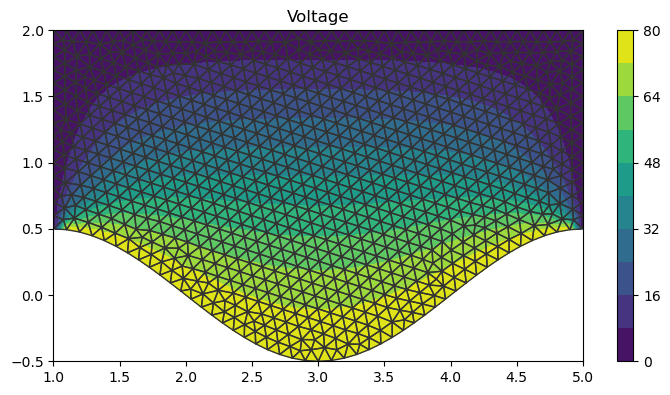

In [255]:
cfvl.figure(fig_size=(7.5, 4))
cfvl.draw_nodal_values_contourf(v, coords, edof, title="Voltage", dofs_per_node=mesh.dofs_per_node, el_type=mesh.el_type, draw_elements=True)
cfvl.colorbar()

In [5]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import pandas as pd
import numpy as np
from numba import njit
import time

export_path = "./latex/illustr/domain_rectangle_dirichlet_only/"
# plots a finite element mesh
def plot_fem_mesh(nodes_x, nodes_y, elements, linewidth: float = 0.2):
    # print(nodes_x)
    it = 0
    for element in elements:
        x = [nodes_x[element[0]], nodes_x[element[1]], nodes_x[element[2]]]
        y = [nodes_y[element[0]], nodes_y[element[1]], nodes_y[element[2]]]
        # print(x , y)
        plt.fill(x, y, edgecolor='black', linewidth = linewidth, fill=False)
        it += 1

@njit()
def mean_square(coords, polygons):
    
    S_el = lambda poly: ((coords[poly[1]][0] - coords[poly[0]][0]) * (coords[poly[2]][1] - coords[poly[0]][1]) - (coords[poly[2]][0] - coords[poly[0]][0]) * (coords[poly[1]][1] - coords[poly[0]][1])) / 2
    res = 0.
    for el in polygons:
        res += S_el(el)
    return round(res / len(polygons), 8)

@njit()
def max_square(coords, polygons):
    
    S_el = lambda poly: ((coords[poly[1]][0] - coords[poly[0]][0]) * (coords[poly[2]][1] - coords[poly[0]][1]) - (coords[poly[2]][0] - coords[poly[0]][0]) * (coords[poly[1]][1] - coords[poly[0]][1])) / 2
    S_max = 0.
    tmp = 0.
    for el in polygons:
        tmp = S_el(el)
        if (tmp > S_max):
            S_max = tmp
    return round(S_max, 8)

@njit()
def exact_solution(x, y, row_num_el: int = 350):
    res = 0
    for n in range(1, row_num_el + 1):
        if n % 2 != 0:
            res += 20 * (1 - (-1) ** n) / (np.pi * n) / (np.exp(- np.pi * n / 2 ) - np.exp( np.pi * n / 2 )) * (np.exp(- np.pi * n / 4 * (2 - y) ) - np.exp( np.pi * n / 4 * (2 - y))) * np.sin(np.pi * n / 4 * x)
    if np.fabs(res) < 1e-15:
        return 0.
    return res


def print_error(x, y, z):
    error_in_node = [];
    for i in range(len(z)):
        error_in_node.append( np.fabs( z[i] - exact_solution(x[i], y[i]) ))

    mean_err = round(np.mean(error_in_node), 4)
    print("Mean error: ", mean_err)

    ind_max = np.argmax(error_in_node)
    print("Max error: ", round(np.max(error_in_node), 4),  f"point: ({round(x[ind_max], 4)}, {round(y[ind_max], 4)})" )
    
    nodes_with_high_err = np.where(error_in_node > mean_err * 1.25)[0]
    # print(nodes_with_high_err)
    coords_with_high_err = []
    
    for j in nodes_with_high_err:
        coords_with_high_err.append([x[j], y[j]])
    coords_with_high_err = np.array(coords_with_high_err).T
    # print(coords_with_high_err)
    return coords_with_high_err

    # for i in range(len(error_in_node)):
    #     if error_in_node[i] > 0.2:
    #         print( x[i], y[i], error_in_node[i])



def print_mean_rel_error(x, y ,z):
    error_in_node = [];
    for i in range(len(z)):
        z_exact = exact_solution(x[i], y[i])
        if np.fabs(z_exact) > 1e-9:
            error_in_node.append( np.divide(np.fabs( z[i] - z_exact ) , z_exact) )
    print("Mean rel error: ", round(np.mean(error_in_node), 8))




@njit
def L2_error_njit(coords, polygons, solution):
    res = 0.

    S_el = lambda poly: ((coords[poly[1]][0] - coords[poly[0]][0]) * (coords[poly[2]][1] - coords[poly[0]][1]) - (coords[poly[2]][0] - coords[poly[0]][0]) * (coords[poly[1]][1] - coords[poly[0]][1])) / 2
    error_in_node = [];
    for poly in polygons:
        Si = S_el(poly)    
        tmp = 0.
        for j in range(3):
            tmp += (exact_solution(coords[poly[j]][0], coords[poly[j]][1]) - solution[poly[j]]) ** 2
        res += Si * tmp / 3
        # res += tmp / 3

    return res

def L2_error(coords, polygons, solution):
    res = L2_error_njit(coords, polygons, solution)
    print(f"L2_error S: {round(res, 8)}")
    pass



Info    : GMSH -> Python-module
Info    : Reading '/tmp/tmpajt26d9m/tempGeometry.geo'...
Info    : Done reading '/tmp/tmpajt26d9m/tempGeometry.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Nurb)
Info    : [ 30%] Meshing curve 2 (Nurb)
Info    : [ 50%] Meshing curve 3 (Nurb)
Info    : [ 80%] Meshing curve 4 (Nurb)
Info    : Done meshing 1D (Wall 0.000729447s, CPU 0.0007s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.168062s, CPU 0.167462s)
Info    : 6790 nodes 13543 elements
Info    : Writing '/tmp/tmpajt26d9m/meshFile.msh'...
Info    : Done writing '/tmp/tmpajt26d9m/meshFile.msh'


mean:  0.00060689
max:  0.00078118
[ 0.  0.  0.  0. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.

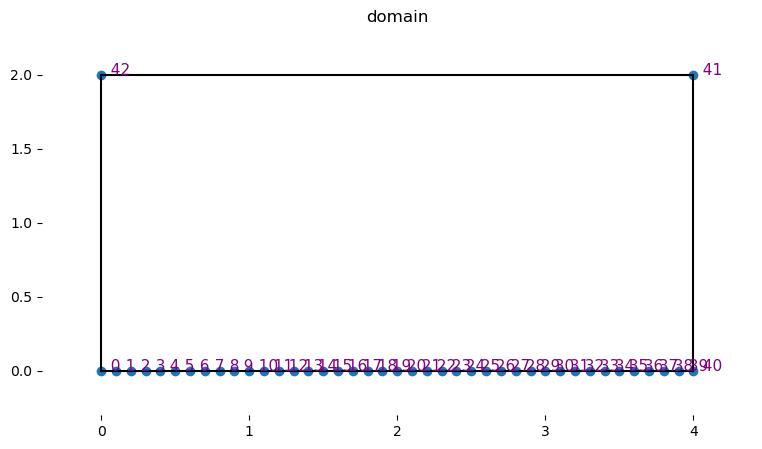

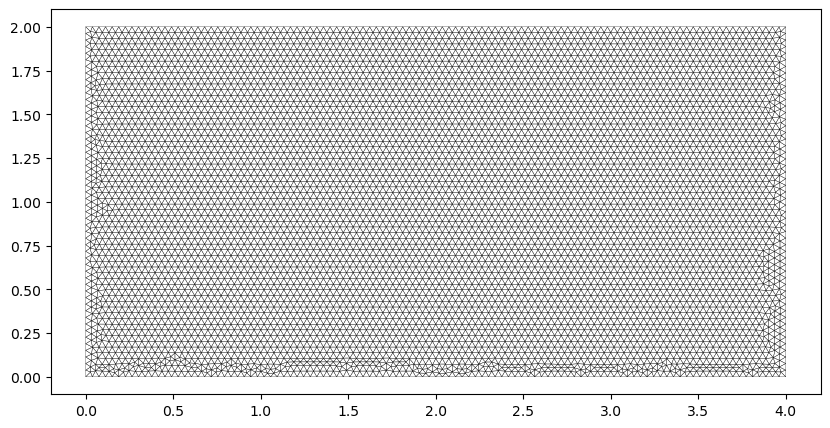

In [19]:
g = cfg.Geometry()

p_coords = []

h = 0.1
x = 0.
ind = []


while x <= 4:
    ind.append(len(p_coords))
    p_coords.append([round(x, 2), 0.])
    x = round(x + h, 2)
    # print([p_coords[-1], len(p_coords) - 1])
    g.point(p_coords[-1], len(p_coords) - 1)

g.spline(ind.copy(), 0)

# print(ind)

g.point([4., 2.], ind[-1] + 1)
ind.append(ind[-1] + 1)


g.spline([ind[-2], ind[-1]] , 1)


g.point([0., 2.], ind[-1] + 1)
ind.append(ind[-1] + 1)

g.spline([ind[-2], ind[-1]] , 2)


g.spline([ind[-1], 0] , 3)


g.surface([0, 1, 2, 3])

for curveID in [0]:
    g.curveMarker(curveID, 10)


cfvl.figure(fig_size=(10,5))
cfvl.draw_geometry(
        g,
        
        label_curves=False,
        title="domain"
)


mesh = cfm.GmshMesh(g)
mesh.elType = 2          # Degrees of freedom per node.
mesh.dofsPerNode = 1     # Factor that changes element sizes.
mesh.elSizeFactor = 0.038 # Element size Factor 
"""
    mesh.elSizeFactor = 0.3325  ~   max S_el = 0.05
    mesh.elSizeFactor = 0.1425  ~   max S_el = 0.01
    mesh.elSizeFactor = 0.042   ~   max S_el = 0.001
    0.029 ~ 0.0005
"""
coords, edof, dofs, bdofs, elementmarkers = mesh.create()

print("mean: ", mean_square(coords, np.array(edof) - 1))
print("max: ", max_square(coords, np.array(edof) - 1))
boundary_voltages = reshape_boundary_dict(bdofs)

for j in range(len(boundary_voltages)):
    if boundary_voltages[j] > 10:
        boundary_voltages[j] = 10
print(boundary_voltages)

cfvl.figure(fig_size=(10,5))
cfvl.draw_mesh(
    coords=coords,
    edof=edof,
    dofs_per_node=mesh.dofs_per_node,
    el_type=mesh.el_type,
    filled=False,
    #title="Example 2 - Mesh"
)
#plot_fem_mesh(coords, edof)


In [23]:
# for i in reversed(range(44, 51)):
#     print(f"""{2.0}, {coords[i][1]}""")

for i in reversed(range(109, 161)):
    # print(f"""{round(coords[i][0],2)}, {round(coords[i][1],2)}""")
    print(f"""0.0, {(coords[i][1])}""")

# print(f"""x,y""")
# for i in coords:
#     print(f"""{i[0]}, {i[1]}""")

0.0, 1.962264150856966
0.0, 1.924528301710454
0.0, 1.886792452582558
0.0, 1.849056603446479
0.0, 1.811320754298945
0.0, 1.773584905229351
0.0, 1.735849056263062
0.0, 1.698113207167079
0.0, 1.660377357983131
0.0, 1.622641508996795
0.0, 1.584905659990719
0.0, 1.547169811047137
0.0, 1.509433962138945
0.0, 1.47169811326328
0.0, 1.433962264077287
0.0, 1.396226415135342
0.0, 1.358490566289339
0.0, 1.320754717434129
0.0, 1.283018868684374
0.0, 1.245283019748156
0.0, 1.207547170843443
0.0, 1.169811321938115
0.0, 1.132075473019081
0.0, 1.094339624070794
0.0, 1.056603775083333
0.0, 1.018867926195189
0.0, 0.9811320771839982
0.0, 0.9433962280338044
0.0, 0.9056603788919976
0.0, 0.8679245296802293
0.0, 0.8301886805558107
0.0, 0.7924528315089232
0.0, 0.7547169823392957
0.0, 0.7169811331483932
0.0, 0.6792452841137793
0.0, 0.641509434962358
0.0, 0.6037735859252895
0.0, 0.5660377367585256
0.0, 0.5283018876011722
0.0, 0.4905660383918587
0.0, 0.4528301892545525
0.0, 0.4150943401309525
0.0, 0.3773584910215

In [21]:
print(f"""p1,p2,p3""")
for i in edof:
    print(f"""{i[0]}, {i[1]}, {i[2]}""")

p1,p2,p3
401, 3911, 3966
3882, 396, 6553
340, 130, 3965
3900, 6538, 6597
3903, 414, 6548
4196, 2926, 4810
5343, 4441, 5344
6538, 420, 6597
396, 3882, 4363
272, 369, 3964
401, 3966, 6581
3884, 399, 6550
3945, 3851, 4469
3912, 404, 4355
4603, 342, 4604
4286, 3612, 5796
4306, 3606, 4321
414, 3903, 6582
3902, 352, 4383
366, 3909, 4213
3910, 369, 4382
3906, 408, 4154
3908, 416, 4191
4607, 4605, 5637
399, 3884, 6587
4441, 5343, 6583
3812, 4246, 6332
135, 331, 3944
4820, 4410, 5136
5136, 4410, 5137
3862, 4607, 5637
4343, 391, 5139
417, 144, 3926
340, 3965, 6558
342, 4603, 6586
3945, 4469, 6598
130, 131, 3965
3912, 4355, 6580
418, 3915, 3916
2926, 4196, 6555
4321, 3606, 6579
271, 272, 3964
2928, 6557, 6585
4196, 4810, 6563
3848, 3882, 6553
3964, 369, 6561
352, 3902, 6577
4482, 2925, 6540
160, 161, 4049
267, 268, 6534
5139, 391, 6591
134, 135, 3944
4286, 5796, 6572
4213, 3909, 6575
3910, 4382, 6576
3911, 401, 3967
6332, 4246, 6584
3913, 351, 4506
144, 145, 3926
408, 3906, 6574
3908, 4191, 4192


In [75]:
# import pandas as pd
# df_x_y = pd.read_csv("./domains/domain_2/mesh0005_test/mesh_nodes.csv")
# df_z = pd.read_csv("./output/domain_2_extra/mesh0005_test/Test_domain_2_rectangle_dirichlet_only_0005_test_solution.csv")
# df_elements = pd.read_csv("./domains/domain_2/mesh0005_test/mesh_polygons.csv")
# co = coords.copy()
# for i in range(len(df_x_y["x"].values)):
#     co[i][0] = df_x_y["x"].values[i]
#     co[i][1] = df_x_y["y"].values[i]

num_elem = len(edof)
num_nodes = len(dofs)

ke = np.zeros((num_elem, 3, 3))

for i in range(num_elem):
    ke[i] = Ke(coords[edof[i] - 1], 1, 1)


In [76]:
def Ke(coords, alpha_x, alpha_y):
    x1 = coords[0,0]
    x2 = coords[1,0]
    x3 = coords[2,0]
    y1 = coords[0,1]
    y2 = coords[1,1]
    y3 = coords[2,1]
    A = 1/2 * np.abs(x1*(y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    M11 = -(alpha_x * (y2 - y3) ** 2  + alpha_y * (x3 - x2) ** 2) / (4 * A)
    M12 = -(alpha_x * (y2 - y3) * (y3 - y1) + alpha_y * (x3 - x2) * (x1 - x3)) / (4 * A)
    M13 = -(alpha_x * (y2 - y3) * (y1 - y2) + alpha_y * (x3 - x2) * (x2 - x1)) / (4 * A)
    M22 = -(alpha_x * (y3 - y1) ** 2 + alpha_y * (x1 - x3) ** 2) / (4 * A)
    M23 = -(alpha_x * (y3 - y1) * (y1 - y2) + alpha_y * (x1 - x3) * (x2 - x1)) / (4 * A)
    M33 = -(alpha_x * (y1 - y2) ** 2 + alpha_y * (x2 - x1) ** 2) / (4 * A)
    return np.matrix(
        [
            [M11, M12, M13],
            [M12, M22, M23],
            [M13, M23, M33]
        ])

In [77]:
K = np.zeros((num_nodes, num_nodes))
for e in range(num_elem):
    for i in range(3):
        for j in range(3):
            K[edof[e,i] - 1, edof[e,j] - 1] += ke[e,i,j]

In [78]:
b = np.zeros(num_nodes)

In [64]:
@njit
def bv(K, b, boundary_voltages):
    for n in (range(len(boundary_voltages))):
        for i in range(len(b)):
            if np.fabs(boundary_voltages[len(boundary_voltages) - 1 - n]) > 1e-16:
                b[i] -= boundary_voltages[len(boundary_voltages) - 1 - n]*K[i, len(boundary_voltages) - 1 - n]
        # b = np.delete(b, len(boundary_voltages) - 1 - n, axis=0)
        # K = np.delete(K, len(boundary_voltages) - 1 - n, axis=0)
        # K = np.delete(K, len(boundary_voltages) - 1 - n, axis=1)
    return K, b

In [65]:
K, b = bv(K, b, boundary_voltages)

In [79]:
for n in reversed (range(len(boundary_voltages))):
    for i in range(len(b)):
        if np.fabs(boundary_voltages[n]) > 1e-16:
            b[i] -= boundary_voltages[n]*K[i, n]
    b = np.delete(b, n, axis=0)
    K = np.delete(K, n, axis=0)
    K = np.delete(K, n, axis=1)

In [80]:
x = np.linalg.solve(K,b)
v = np.zeros(num_nodes-len(x))
v = np.concatenate((boundary_voltages,x))

In [28]:
v

array([0.        , 0.        , 0.        , ..., 2.87458561, 0.18075911,
       3.59811319])

Mean error:  0.0117
Max error:  0.5601 point: (3.9023, 0.0983)
L2_error S: 0.01100101
[[0.13793103 0.27586207 0.4137931  0.55172414 0.68965517 1.65517242
  1.79310345 1.93103449 2.06896552 2.20689656 2.34482759 3.31034483
  3.44827586 3.5862069  3.72413793 3.86206897 0.48251177 3.51758518
  0.10679962 3.88452995 0.2047805  3.7953979  0.34448327 0.41379378
  0.5506393  0.48187405 0.61840682 0.54990464 0.68623038 0.61779675
  0.75409396 0.68554979 0.54931759 3.22771577 3.29555035 3.36431103
  3.4319236  0.82244822 3.5004819  3.56781218 3.43306892 3.56905083
  0.41371817 3.23092788 3.50171437 3.63770707 0.68832078 3.69436259
  3.69437073 0.29011112 0.28681143 0.34621877 0.27980862 0.34862227
  3.65583102 3.70923615 3.57839171 3.63375469 3.30731002 0.48217943
  0.41644169 3.44360862 3.29694731 0.6199932  0.13614435 3.88697338
  0.754908   3.3658795  0.09961156 3.89899995 3.77518249 3.75205419
  0.22563502 0.22995074 0.09768324 3.90225376 3.79846092 0.18472763
  3.81499924]
 [0.         0. 

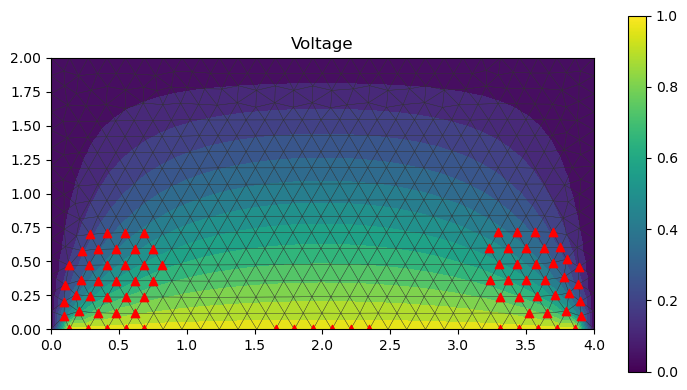

In [83]:

cfvl.figure(fig_size=(7.5, 4))

coords_with_high_err = print_error(np.array(coords).T[0], np.array(coords).T[1], v)
L2_error(np.array(coords), np.array(edof) - 1, v)
print(coords_with_high_err)

plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

# plot_fem_mesh(np.array(coords).T[0], np.array(coords).T[1], np.array(edof) - 1, 0.2)
plt.scatter(coords_with_high_err[0], coords_with_high_err[1], marker="^", color="red")
# plt.axis([0, 4, 0, 2])


cfvl.draw_nodal_values_contourf(v, coords, edof, title="Voltage", dofs_per_node=mesh.dofs_per_node, el_type=mesh.el_type, draw_elements=True)
plt.scatter(coords_with_high_err[0], coords_with_high_err[1], marker="^", color="red")

cfvl.colorbar()